In [44]:
#import conda
import shap
import numpy as np
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.privacy import DPExplainableBoostingClassifier, DPExplainableBoostingRegressor
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.glassbox import ClassificationTree
from interpret import show
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [45]:
def plot_confusion_matrix(cm, classes=[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize_val=6.5):

    fig=plt.figure(figsize=(figsize_val,figsize_val))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [46]:
def generate_synthetic_dataset(num_samples, num_features, num_important_features, test_size=0.25, random_seed=None, noise=0.6):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate random values for all features within a limited range
    dataset = np.random.uniform(0, 1, size=(num_samples, num_features))
    
    # Generate important features
    important_features = np.random.choice(num_features, num_important_features, replace=False)
    
    # Generate target values as the sum of important features plus some noise
    #y = dataset[:, important_features].sum(axis=1)
    y = np.random.uniform(0, 0.5, size=(num_samples))

    # If important feature is higher than 0.99, set y to a value between 0.9 and 1
    for feature in important_features:
        y[dataset[:, feature] > 0.5] = np.random.uniform(0.5, 1, size=(dataset[:, feature] > 0.5).sum())

    # Add noise to the target values
    y += np.random.uniform(-noise, noise, size=y.shape)
    y_min, y_max = y.min(), y.max()
    y = (y - y_min) / (y_max - y_min)
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=test_size, random_state=random_seed)

    y_train_d = (y_train >= 0.5).astype(int)
    y_test_d = (y_test >= 0.5).astype(int)
    
    return X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d

In [47]:
set_visualize_provider(InlineProvider())
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=100000, 
                                                                                                        num_features=4, 
                                                                                                        num_important_features=1, 
                                                                                                        random_seed=42)
print(important_features)

dt = ClassificationTree(random_state=1)
dt.fit(X_train, y_train_d)
score = dt.score(X_test, y_test_d)

# make a prediction
print(score)
predictions = dt.predict(X_test)
dt_global = dt.explain_global()

[1]
0.71272


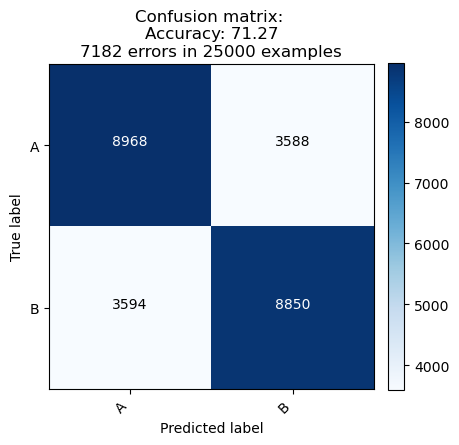

In [48]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

In [49]:
show(dt_global)
dt_local = dt.explain_local(X_test[:50], y_test_d[:50])
show(dt_local)

In [28]:
set_visualize_provider(InlineProvider())
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=100000, 
                                                                                                        num_features=8, 
                                                                                                        num_important_features=1, 
                                                                                                        random_seed=42)
print(important_features)

dt = ClassificationTree(random_state=1)
dt.fit(X_train, y_train_d)
score = dt.score(X_test, y_test_d)

# make a prediction
print(score)
predictions = dt.predict(X_test)
dt_global = dt.explain_global()

[0]
0.70956


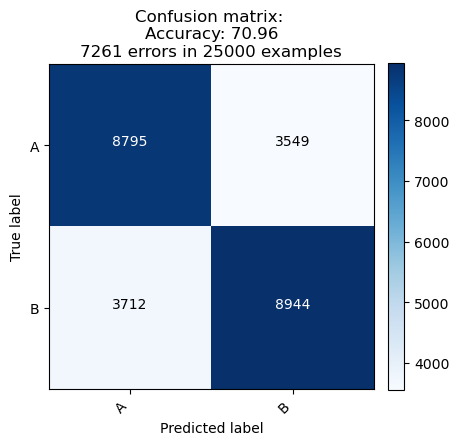

In [29]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

In [30]:
show(dt_global)

dt_local = dt.explain_local(X_test[:50], y_test_d[:50])
show(dt_local)

In [31]:
set_visualize_provider(InlineProvider())
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=100000, 
                                                                                                        num_features=4, 
                                                                                                        num_important_features=2, 
                                                                                                        random_seed=42)
print(important_features)

dt = ClassificationTree(random_state=1)
dt.fit(X_train, y_train_d)
score = dt.score(X_test, y_test_d)

# make a prediction
print(score)
predictions = dt.predict(X_test)
dt_global = dt.explain_global()

[1 2]
0.70388


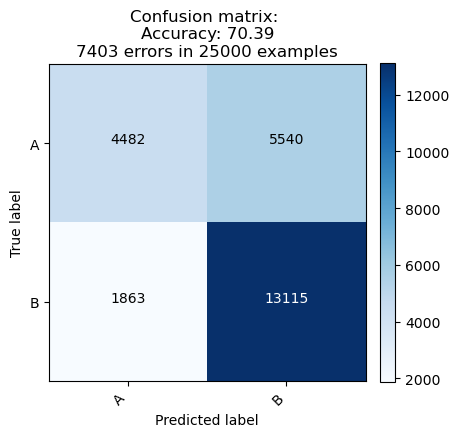

In [32]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

In [33]:
show(dt_global)

dt_local = dt.explain_local(X_test[:50], y_test_d[:50])
show(dt_local)

In [34]:
set_visualize_provider(InlineProvider())
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=100000, 
                                                                                                        num_features=8, 
                                                                                                        num_important_features=3, 
                                                                                                        random_seed=42)
print(important_features)

dt = ClassificationTree(random_state=1)
dt.fit(X_train, y_train_d)
score = dt.score(X_test, y_test_d)

# make a prediction
print(score)
predictions = dt.predict(X_test)
dt_global = dt.explain_global()

[0 1 5]
0.70884


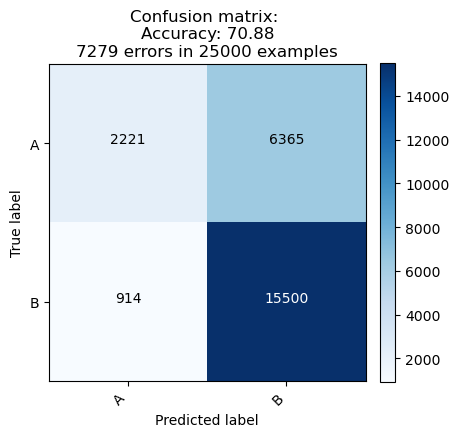

In [35]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

In [36]:
show(dt_global)

dt_local = dt.explain_local(X_test[:50], y_test_d[:50])
show(dt_local)